# Demo for Real Time Gait Asymmetry Detection Model Task

The current notebook is going to be a demo of the real time asymmetry detection model capabilities, while also being used as the initial steps for the creation of the pipeline of the deployed version.

In [1]:
# Import Liraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.linear_model import LogisticRegression
import time, sys, joblib
sys.path.insert(0, '..')

from support_functions import simulate_gait_signal, summarize
from feature_extraction import asymmetry_index, symmetry_ratio

In [2]:
# Create a generated dataset of gait data on a two second window for 
def generate_simulated_window(healthy: bool=True):
    '''
    Generate a simulated window of gait data for a healthy or stroke subject.
    healthy (bool): Boolean value indicating healthy or stroke subject
    '''
    fs = 100
    left = simulate_gait_signal(amplitude=400, freq=1.0, phase_shift=0.0, noise=2.0)
    if healthy:
        right = simulate_gait_signal(amplitude=350, freq=1.0, phase_shift=0.0, noise=2.0)
    else:
        right = simulate_gait_signal(amplitude=280, freq=1.0, phase_shift=0.1, noise=2.0)
    
    left_peaks, _  = find_peaks(left, height=10, distance=30)
    right_peaks, _ = find_peaks(right, height=10, distance=30)

    left_stride_times  = np.diff(left_peaks)
    right_stride_times = np.diff(right_peaks)

    asymmetry = asymmetry_index(left_stride_times, right_stride_times)
    symmetry  = symmetry_ratio(left_stride_times, right_stride_times)

    return {
        "left": left,
        "right": right,
        "asymmetry_index": summarize(asymmetry),
        "symmetry_ratio": summarize(symmetry)
    }

In [3]:
# Load the model and the scaler
model = joblib.load('/Users/stamatiosorphanos/Documents/GaitRehab/models/detection_asymmetry_randomforest.pkl')
scaler = joblib.load('/Users/stamatiosorphanos/Documents/GaitRehab/models/detection_asymmetry_scaler.pkl')

print('Input features:', model.n_features_in_)
print('Classes:', model.classes_)

Input features: 2
Classes: [0 1]


In [4]:
# Generate Simulated Left and Right Gait Signals

# Run Simulation
def run_simulation(label="healthy"):
    healthy = label.lower() == "healthy"
    win = generate_simulated_window(healthy=healthy)

    print(f"Asymmetry Index (mean): {win['asymmetry_index']:.4f}")
    print(f"Symmetry Ratio (mean): {win['symmetry_ratio']:.4f}")

    features = np.array([[win['asymmetry_index'], win['symmetry_ratio']]])
    pred = model.predict(features)[0]
    label_pred = "ASYMMETRIC" if pred == 1 else "SYMMETRIC"

    print(f"Predicted Gait State: {label_pred}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(win['left'], label='Left Shank')
    plt.plot(win['right'], label='Right Shank')
    plt.title(f"Simulated Gait — Prediction: {label_pred}")
    plt.xlabel("Time steps")
    plt.ylabel("Rotation (deg/s)")
    plt.legend()
    plt.grid(True)
    plt.show()



Simulating Healthy Gait
Asymmetry Index (mean): 0.0101
Symmetry Ratio (mean): 0.9800
Predicted Gait State: SYMMETRIC


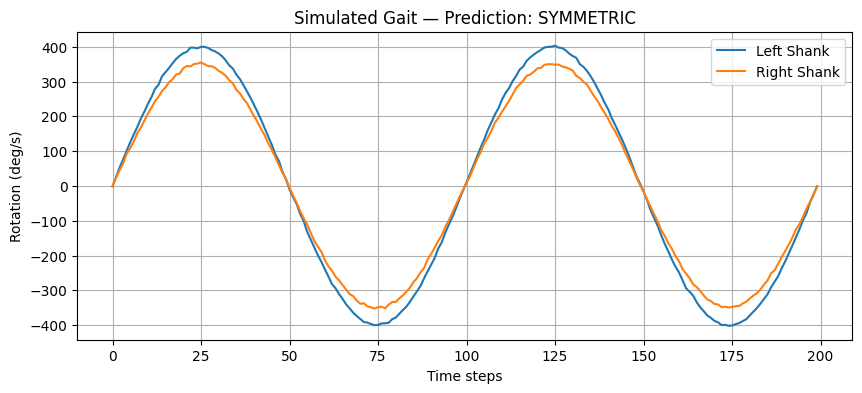


Simulating Stroke (Asymmetric) Gait
Asymmetry Index (mean): -0.0100
Symmetry Ratio (mean): 0.9802
Predicted Gait State: SYMMETRIC


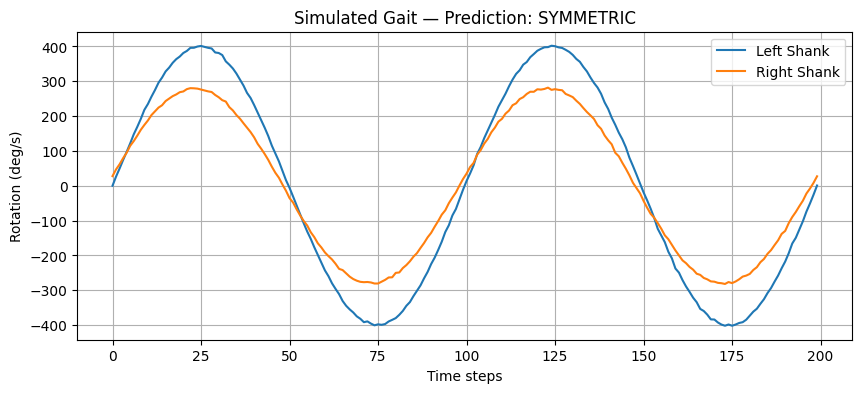

In [5]:
# ## Demo: Simulate Healthy and Stroke Gait
print("Simulating Healthy Gait")
run_simulation(label="healthy")

print("\nSimulating Stroke (Asymmetric) Gait")
run_simulation(label="stroke")